In [61]:
import os
import random
import matplotlib.pyplot as plt
import scienceplots

from surprise import Dataset, Reader, NormalPredictor, BaselineOnly, KNNBasic, KNNWithMeans, KNNWithZScore, accuracy, SlopeOne
from surprise.model_selection import train_test_split, GridSearchCV

# Define a random state so that the train test splits can be reproducible
RANDOM_STATE = 128

# Add this path to use SciencePlots (it uses latex)
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"

plt.rcParams["figure.figsize"] = (100,100)
plt.style.use(['science', 'scatter'])

We will be using `surprise` to compare several NN based algorithms and a basic Matrix Factorization technique as presented in the original paper. Let's make a table of comparison of each algorithm to check the superiority of Matrix Factorization techniques. 

### Generate train and test sets

In [3]:
# path to dataset file
file_path = "../ml-100k/u.data"
reader = Reader(line_format="user item rating timestamp", sep="\t")
data = Dataset.load_from_file(file_path, reader=reader)

# Get raw ratings from `Dataset` object
raw_ratings = data.raw_ratings

# Shuffle the raw ratings and select train and test splits (75 % / 25 %)
random.Random(RANDOM_STATE).shuffle(raw_ratings)
threshold = int(0.75 * len(raw_ratings))
train_raw_ratings = raw_ratings[:threshold]
test_raw_ratings = raw_ratings[threshold:]

# Set `Dataset` `raw_rating` property to `train_raw_ratings`. We will be using this object from GridSearch
data.raw_ratings = train_raw_ratings  # data is now the set A
assert len(data.raw_ratings) == 75000

train_dataset = data
trainset = data.build_full_trainset()
testset = data.construct_testset(test_raw_ratings)

### Basic Algorithms 

These two algorithms are useful as baselines.

##### Normal Predictor

In [5]:
normal_predictor = NormalPredictor()
normal_predictor.fit(trainset)
predictions = normal_predictor.test(testset)

# MAE and RMSE
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

RMSE: 1.5219
MAE:  1.2199


In [6]:
print(f"RMSE: {rmse} | MAE: {mae}")

RMSE: 1.521873875887593 | MAE: 1.2198513109142557


##### Baseline Predictor

We will obtain b_u and b_i using alternating least squares and using regularization on both parameters. We will be using the default parameters in `surprise`. That is, a `reg_i` of 10, `reg_u` of 15 and 10 epochs.

In [7]:
baseline_predictor = BaselineOnly()
baseline_predictor.fit(trainset)
predictions = baseline_predictor.test(testset)

# MAE and RMSE
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

Estimating biases using als...
RMSE: 0.9476
MAE:  0.7529


In [8]:
print(f"RMSE: {rmse} | MAE: {mae}")

RMSE: 0.9476210485869836 | MAE: 0.752901554880153


### User-based KNN

As the number of users in the MovieLens set is smaller than the number of items, the use of user-based CF algorithms seems to be more justified.  Therefore, we will show three modalities of these versus a single example of item-based algorithms in the next subsection. We will be using GridSearch to check the best number of neighbors `k`.

##### KNN Basic

In [30]:
param_grid = {"k": range(10, 100, 10), "sim_options": {"name": ["msd"], "user_based": [True]}}
gs = GridSearchCV(KNNBasic, param_grid, measures=["rmse", "mae"], cv=3)
gs.fit(train_dataset)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [34]:
mean_rmse = gs.cv_results["mean_test_rmse"]
mean_mae = gs.cv_results["mean_test_mae"]

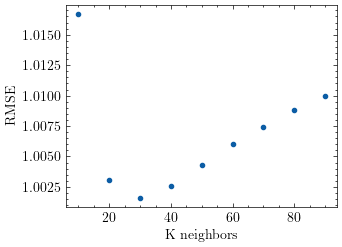

In [45]:
plt.scatter(x=range(10, 100, 10), y=mean_rmse)
plt.xlabel("K neighbors")
plt.ylabel("RMSE")
plt.show()

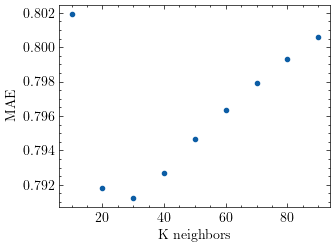

In [46]:
plt.scatter(x=range(10, 100, 10), y=mean_mae)
plt.xlabel("K neighbors")
plt.ylabel("MAE")
plt.show()

As we can see, the optimal number of neighbors is around 30. Now, simply train the model for this paremeter.

In [49]:
knn_basic = KNNBasic(k=30, sim_options={"name": "msd"})
knn_basic.fit(trainset)
predictions = knn_basic.test(testset)

# MAE and RMSE
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9827
MAE:  0.7775


In [50]:
print(f"RMSE: {rmse} | MAE: {mae}")

RMSE: 0.9826580327023857 | MAE: 0.777536869506387


##### KNN with Mean Centering

In [51]:
param_grid = {"k": range(10, 100, 10), "sim_options": {"name": ["msd"], "user_based": [True]}}
gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=3)
gs.fit(train_dataset)

mean_rmse = gs.cv_results["mean_test_rmse"]
mean_mae = gs.cv_results["mean_test_mae"]

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

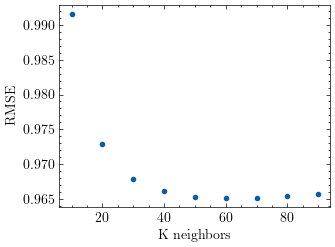

In [52]:
plt.scatter(x=range(10, 100, 10), y=mean_rmse)
plt.xlabel("K neighbors")
plt.ylabel("RMSE")
plt.show()

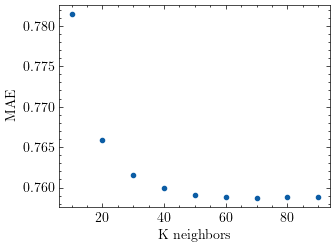

In [53]:
plt.scatter(x=range(10, 100, 10), y=mean_mae)
plt.xlabel("K neighbors")
plt.ylabel("MAE")
plt.show()

In [55]:
knn_withmeans = KNNWithMeans(k=60, sim_options={"name": "msd"})
knn_withmeans.fit(trainset)
predictions = knn_withmeans.test(testset)

# MAE and RMSE
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9530
MAE:  0.7518


##### KNN with Zscore 

In [56]:
param_grid = {"k": range(10, 100, 10), "sim_options": {"name": ["msd"], "user_based": [True]}}
gs = GridSearchCV(KNNWithZScore, param_grid, measures=["rmse", "mae"], cv=3)
gs.fit(train_dataset)

mean_rmse = gs.cv_results["mean_test_rmse"]
mean_mae = gs.cv_results["mean_test_mae"]

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

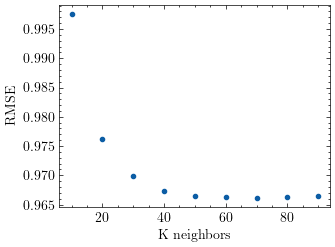

In [57]:
plt.scatter(x=range(10, 100, 10), y=mean_rmse)
plt.xlabel("K neighbors")
plt.ylabel("RMSE")
plt.show()

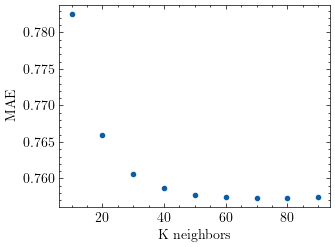

In [58]:
plt.scatter(x=range(10, 100, 10), y=mean_mae)
plt.xlabel("K neighbors")
plt.ylabel("MAE")
plt.show()

In [59]:
gs.best_params

{'rmse': {'k': 70, 'sim_options': {'name': 'msd', 'user_based': True}},
 'mae': {'k': 70, 'sim_options': {'name': 'msd', 'user_based': True}}}

In [60]:
knn_withzscore = KNNWithZScore(k=70, sim_options={"name": "msd"})
knn_withzscore.fit(trainset)
predictions = knn_withzscore.test(testset)

# MAE and RMSE
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9529
MAE:  0.7481


### Item-based KNN (Slope One)

Finally as an example of Item-based we will be using the famous SlopeOne algorithm.

In [65]:
slope_one = SlopeOne()
slope_one.fit(trainset)
predictions = slope_one.test(testset)

# MAE and RMSE
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

RMSE: 0.9493
MAE:  0.7485


In the next notebook we will be implementing a traditional Matrix Factorization technique using `PyTorch`. Then, we wil try to include poster information using this same framework, trying to beat the results obtained with `RMSE` and `MAE` metrics.